<a href="https://colab.research.google.com/github/juno-yuu/MFE-DAML/blob/main/Problem_Set_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Set 3

### Question 1: Predicting default



#### a. We will use the column "loan_status" as the indicator for whether the loan was paid or there was a default.
i) Drop all rows where "loan_status" is not equal to either "Fully Paid" or "Charged Off." Define the new variable Default as 1 (or TRUE) if "loan_status" is equal to "Charged Off", and 0 (or FALSE) otherwise.

In [1]:
import os
import pandas  as pd
import seaborn as sns
import numpy   as np
import matplotlib.pyplot       as plt
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy.optimize import minimize
from matplotlib import cm
import statsmodels.api as sm
from patsy import dmatrices
from scipy.stats import chi2
from sklearn.metrics import roc_curve, auc
import pylab as pl
from prettytable import PrettyTable

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# mount your Google Drive so you can locate your data files.
from google.colab import drive
drive.mount('/content/drive')#@title

Mounted at /content/drive


In [4]:
#load data
df = pd.read_csv("/content/LendingClub_LoanStats3a_v12.csv")
#select rows of Fully Paid and Charged off
df = df[(df['loan_status'] == "Fully Paid") | (df['loan_status'] == "Charged Off")]
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (21,24,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee
0,1077501,1296599,5000,5000,4975.0,36 months,0.1065,162.870000,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1,3,0,13648,83.70%,9,f,0,0.0,5863.1553,5833.8398,5000.00000,863.15997,0.000000,0.0,0.00
1,1077430,1314167,2500,2500,2500.0,60 months,0.1527,59.830002,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,bike,309xx,GA,1,0.0,Apr-99,5,3,0,1687,9.40%,4,f,0,0.0,1014.5300,1014.5300,456.45999,435.17001,0.000000,122.9,1.11
2,1077175,1313524,2400,2400,2400.0,36 months,0.1596,84.330002,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2,2,0,2956,98.50%,10,f,0,0.0,3005.6667,3005.6699,2400.00000,605.66998,0.000000,0.0,0.00
3,1076863,1277178,10000,10000,10000.0,36 months,0.1349,339.310000,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,personel,917xx,CA,20,0.0,Feb-96,1,10,0,5598,21%,37,f,0,0.0,12231.8900,12231.8900,10000.00000,2214.91990,16.969999,0.0,0.00
5,1075269,1311441,5000,5000,5000.0,36 months,0.0790,156.460010,A,A4,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.2,0.0,Nov-04,3,9,0,7963,28.30%,12,f,0,0.0,5632.2100,5632.2100,5000.00000,632.21002,0.000000,0.0,0.00


In [5]:
# Create a new varaible
def conditions(x):
  if x == 'Charged Off':
    return 1
  else:
    return 0

func = np.vectorize(conditions)
#define a new variable Default
df['Default']=func(df['loan_status']) # transform to dummy variables 
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,Default
0,1077501,1296599,5000,5000,4975.0,36 months,0.1065,162.870000,B,B2,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1,3,0,13648,83.70%,9,f,0,0.0,5863.1553,5833.8398,5000.00000,863.15997,0.000000,0.0,0.00,0
1,1077430,1314167,2500,2500,2500.0,60 months,0.1527,59.830002,C,C4,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,car,bike,309xx,GA,1,0.0,Apr-99,5,3,0,1687,9.40%,4,f,0,0.0,1014.5300,1014.5300,456.45999,435.17001,0.000000,122.9,1.11,1
2,1077175,1313524,2400,2400,2400.0,36 months,0.1596,84.330002,C,C5,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2,2,0,2956,98.50%,10,f,0,0.0,3005.6667,3005.6699,2400.00000,605.66998,0.000000,0.0,0.00,0
3,1076863,1277178,10000,10000,10000.0,36 months,0.1349,339.310000,C,C1,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,other,personel,917xx,CA,20,0.0,Feb-96,1,10,0,5598,21%,37,f,0,0.0,12231.8900,12231.8900,10000.00000,2214.91990,16.969999,0.0,0.00,0
5,1075269,1311441,5000,5000,5000.0,36 months,0.0790,156.460010,A,A4,3 years,RENT,36000.0,Source Verified,Dec-11,Fully Paid,n,wedding,My wedding loan I promise to pay back,852xx,AZ,11.2,0.0,Nov-04,3,9,0,7963,28.30%,12,f,0,0.0,5632.2100,5632.2100,5000.00000,632.21002,0.000000,0.0,0.00,0


(ii) Report the average default rate in the sample (number of defaults divided by total number of loans)

In [6]:
# number of default
default_num = np.sum(df['Default'])
#get total number of loans
#[Note to myself]: total_rows = len(df.axes[0])
#          total_cols = len(df.axes[1])
loan_num = len(df.axes[0])
#average default rate
default_rate = default_num/(loan_num)
print("The average default rate in the sample is {:.4%}".format(default_rate))


The average default rate in the sample is 14.3535%


#### b. LendingClub gives a "grade" to each borrower, designed as a score of each borrowers creditworthiness. The best grade is "A", the worst grade is "G".
i) Run a logistic regression of the Default variable on the grade. Report and explain the regression output. I.e., what is the interpretation of the coefficients? Do the numbers 'make sense'.

In [7]:
df['c'] = 1
y,Xf = dmatrices('Default ~ C(grade)',df,return_type = 'dataframe')
logit_grade = sm.GLM(y,Xf,family=sm.families.Binomial()).fit()
logit_grade.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39405
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15457.
Date:                Thu, 15 Apr 2021   Deviance:                       30914.
Time:                        21:29:19   Pearson chi2:                 3.94e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.7554      0.042    -65.554      0.000      -2.838      -2.673
C(grade)[T.B]     0.7614      0.051     15.045      0.000       0.662       0.861
C(grade)[T.C]     1.1597      0.052     22.503      0.000       1.059       1.261
C(grade)[T.D]     1.4600      0.054     27.130      0.000       1.355       1.565
C(grade)[T.E]     1.6983      0.060     28.167      0.000       1.580       1.817
C(grade)[T.F]     1.9732      0.079     24.874      0.000       1.818       2.129
C(grade)[T.G]     2.0139      0.128     15.734      0.000       1.763       2.265
=================================================================================
"""



> Take Grade B as an example, The coefficient of grade B is equal to 0.7614, which means, holding other variables fixed, the defualt rate is
 0.76 unit higher than our base level, Grade A rating borrowers. 



> I would say the coefficients make sense to me, as grade "A" are for borrowers with best creditworthiness and "G" are for people that can be trusted less. The coefficients of the grade ratings are increasing with grade, which means default rates are increasing. This corresponds to the idea of design the creditworthiness score.







ii)Construct and report a test of whether the model performs better than the null model where only "beta0", and no conditioning information, is present in the logistic model.

In [63]:
# run logstic null model
y,X = dmatrices('Default ~ 1',df,return_type = 'dataframe')
logit_grade_null = sm.GLM(y,X,family=sm.families.Binomial()).fit()
logit_grade_null.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39411
Model Family:                Binomial   Df Model:                            0
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16211.
Date:                Thu, 15 Apr 2021   Deviance:                       32423.
Time:                        23:35:19   Pearson chi2:                 3.94e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7862      0.014   -124.333      0.000      -1.814      -1.758
==============================================================================
"""

In [62]:
# do Inclusion-Exclusion Test
delta_df= logit_grade.df_model - logit_grade_null.df_model #number of variables thrown out = 6
delta_dev=logit_grade_null.deviance-logit_grade.deviance #Change in fit. Fit is worse for simpler model by # “deviance” points
#p-value test
p_value_chisq = 1-chi2.cdf(delta_dev,delta_df) 
print('{0} variables has be thrown out by fitting the null model. The null model fit is worse for null model by {1} "deviance" points. p-value is {2}'.format(delta_df,delta_dev,p_value_chisq))

6 variables has be thrown out by fitting the null model. The null model fit is worse for null model by 1508.097255675224 "deviance" points. p-value is 0.0


By Inclusion-Exclusion Test, p-value is $0$, so that we reject the null hypothesis, which is to say, there is a difference between pool regression vs. null model. The grade model performs better.

iii) Construct the lift table and the ROC curve for this model. Explain the interpretation of
the numbers in the lift table and the lines and axis in the ROC curve. Does the model perform better than a random guess?



> Sort the data by fitted probabilities and then compute the mean of the
Y variable (mean response – in this case, mean default rate) for each decile of fitted probabilities.



In [69]:
# fitted probability 
df['phat'] = logit_grade.predict(Xf)
# compute a "lift" table
# Get quantiles
df['rank'] = df['phat'].rank(method='first')
df = df.sort_values(by=['rank'])
df['deciles'] = pd.qcut(df['rank'].values, 10,labels=np.arange(1, 11, 1))
df1 = df[['deciles','phat','Default']] 
lift = df1.groupby('deciles')[['deciles','Default']].mean()
lift['Lift Factor'] = lift['Default']/np.mean(df.Default)
lift =lift.sort_values(by=['Default'])
lift=lift.sort_values(by=['Default'])
lift['Deciles'] = np.arange(1,11,1)
lift

,Default,Lift Factor,Deciles
deciles,,,
2,0.054047,0.376544,1
1,0.069001,0.480723,2
3,0.090586,0.631109,3
5,0.114945,0.800818,4
4,0.118752,0.827336,5
6,0.147171,1.025330,6
7,0.170515,1.187969,7
8,0.191322,1.332930,8
9,0.206039,1.435463,9




> From the lift table, we can see that the mean response rate for high fitted probailities would much much higher than the lowest fitted probabilities.



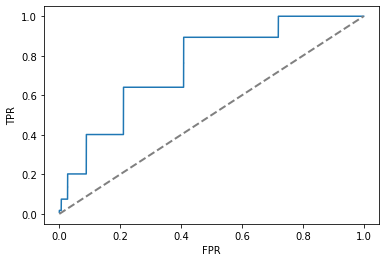

In [97]:
# create ROC curve
def simple_roc(labels,scores):
    labels = np.flip([x for _,x in sorted(zip(scores,labels),reverse = False)])
    return pd.DataFrame({'TPR': np.cumsum(labels)/sum(labels),
                         'FPR': np.cumsum(~labels)/sum(~labels)})
glm_simple_roc = simple_roc(df.Default==1,df.phat)
plt.figure()
ax = sns.lineplot(data=glm_simple_roc, x="FPR", y="TPR")
plt.plot([0, 1], [0, 1],color='grey', linestyle='dashed', linewidth=2)


The yellow line here represents the random guess. By the area under the curve we can see that the model does better than the random guess.

iv) Assume that each loan is for $\$100$, and that you make a $\$1$ profit if there is no default, but lose $\$10$ if there is a default (both given in present value terms to keep things easy). Using data from the ROC curve (True Positive Rate and False Positive Rate) along with the average rate of default (total number of defaults divided by total number of loans), what is the cutoff default probability you should use as your decision criterion to maximize profits? Plot the corresponding point on the ROC curve.



> The optimal CutOff value is the point where there is high true positive rate and low false positive rate. Given the payoff of the loan, we could derive the coding logic as followings:
 As we are maximizing function: 
 \begin{align*}
 N(1-\text{FPR(cutoff)}) \times 1 + P(1-\text{TPR(cutoff})) \times (-10) &= N-N\times \text{FPR(cutoff)} -10 P + 10 P \times \text{TPR(cutoff)}\\
 &= N-10P -FP+10 TP
 \end{align*}
 As $N-10P$ is fixed, therefore, we only need to find the max difference between $10 TP-FP$



Text(0.6195082210042957, 1.01, 'Cut-off Point')

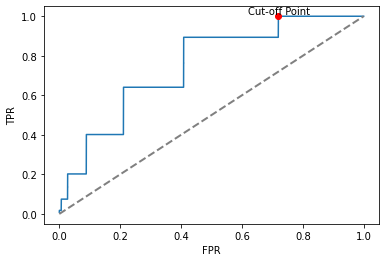

In [98]:
optimal_idx = np.argmax(10*glm_simple_roc['TPR'] - 1*glm_simple_roc['FPR'])
optimal_fpr = glm_simple_roc['FPR'][optimal_idx]
optimal_tpr = glm_simple_roc['TPR'][optimal_idx]
optimal_fpr,optimal_tpr
plt.figure()
ax = sns.lineplot(data=glm_simple_roc, x="FPR", y="TPR")
plt.plot([0, 1], [0, 1],color='grey', linestyle='dashed', linewidth=2)
plt.plot(optimal_fpr, optimal_tpr,"or ")
plt.annotate("Cut-off Point", (optimal_fpr-0.1, optimal_tpr+0.01))

#### c. Next, we will see if it is possible to do better than the internal "grade"-variable, using other information about the borrower and the loan as provided by LendingClub.

 i) First, consider a logistic regression model that uses only loan amount (loan_amnt) and annual income (annual_inc) as explanatory variables. Report the regression results.

In [64]:
# fit gression uses loan_amnt, annual_inc
y,X2 = dmatrices('Default ~ loan_amnt + annual_inc',df,return_type = 'dataframe')
logit_model = sm.GLM(y,X2,family=sm.families.Binomial()).fit()
logit_model.summary() #regression output

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39409
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16013.
Date:                Thu, 15 Apr 2021   Deviance:                       32027.
Time:                        23:42:32   Pearson chi2:                 6.67e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.7254      0.032    -53.708      0.000      -1.788      -1.662
loan_amnt   3.484e-05   2.08e-06     16.742      0.000    3.08e-05    3.89e-05
annual_inc -7.089e-06   4.66e-07    -15.201      0.000      -8e-06   -6.17e-06
==============================================================================
"""

In [70]:
# fitted probability 
df['phat2'] = logit_model.predict(X2)
# compute a "lift" table
# Get quantiles
df['deciles'] = pd.qcut(df['phat2'].values, 10,labels=np.arange(1, 11, 1))
#df['deciles'] = pd.qcut(df['phat'].rank(method='first'),10,labels=np.arange(1, 11, 1)).codes
df1 = df[['deciles','phat','Default']] 
lift_model = df1.groupby('deciles')[['deciles','Default']].mean()
lift_model['Lift Factor_model'] = lift_model['Default']/np.mean(df.Default)
lift_model

,Default,Lift Factor_model
deciles,,
1,0.088466,0.616341
2,0.104622,0.728893
3,0.112180,0.781554
4,0.126367,0.880389
5,0.132707,0.924565
6,0.142603,0.993510
7,0.153436,1.068983
8,0.149784,1.043538
9,0.202487,1.410713


In [75]:
#compare two lift table
table_compare = pd.concat([lift_model, lift],axis=1)
table_compare

,Default,Lift Factor_model,Default,Lift Factor,Deciles
deciles,,,,,
1,0.088466,0.616341,0.069001,0.480723,2
2,0.104622,0.728893,0.054047,0.376544,1
3,0.112180,0.781554,0.090586,0.631109,3
4,0.126367,0.880389,0.118752,0.827336,5
5,0.132707,0.924565,0.114945,0.800818,4
6,0.142603,0.993510,0.147171,1.025330,6
7,0.153436,1.068983,0.170515,1.187969,7
8,0.149784,1.043538,0.191322,1.332930,8
9,0.202487,1.410713,0.206039,1.435463,9




> By comparing the Lift tables of this model and the grade model, we can see grade model do better than this model, as it differentiate the mean response rate for high fitted probabilities and low fitted probabilities better.



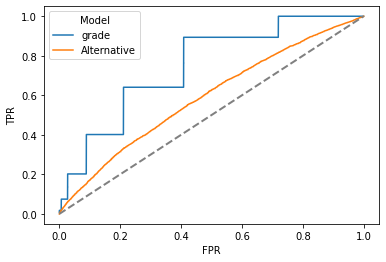

In [83]:
#plot ROC curve for the alternative model, that uses only
glm_altenative_roc = simple_roc(df.Default==1,df.phat2)
glm_simple_roc['Model'] = 'grade'
glm_altenative_roc['Model'] = 'Alternative'

New_ROC=glm_simple_roc.append(glm_altenative_roc)
plt.figure()
ax = sns.lineplot(data=New_ROC, x="FPR", y="TPR",hue='Model')
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed',linewidth=2)



> By comparing the ROC curve of both models, we can see the AUC of grade model is larger and the alternative model is closer to the random guess line, grey dash line. We can also see that the grade model performs better. 




ii) Now, include also information from the loan itself. In particular, include the maturity of the loan (term) and the interest rate (int_rate) in the logistic regression. Report the output. How does Python handle the term variable? In particular, what is the interpretation of the regression coefficient? Again show the lift table and ROC curve relative to the original 'grade' model. Now, which model is better? What is the likely explanation for why this new model performs better/worse?

In [84]:
# fit gression uses loan_amnt, annual_inc,term, int_rate
y,X3 = dmatrices('Default ~ loan_amnt + annual_inc + term + int_rate',df,return_type = 'dataframe')
logit_model3 = sm.GLM(y,X3,family=sm.families.Binomial()).fit()
logit_model3.summary() #regression output

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39407
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15209.
Date:                Fri, 16 Apr 2021   Deviance:                       30418.
Time:                        00:17:20   Pearson chi2:                 4.68e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -3.2660      0.061    -53.941      0.000      -3.385      -3.147
term[T. 60 months]     0.4538      0.036     12.732      0.000       0.384       0.524
loan_amnt           1.176e-06   2.31e-06      0.509      0.611   -3.35e-06    5.71e-06
annual_inc         -6.117e-06   4.64e-07    -13.173      0.000   -7.03e-06   -5.21e-06
int_rate              13.4873      0.456     29.575      0.000      12.593      14.381
======================================================================================
"""

We can tell by the output that Python treats term as a dummy variable, it transforms term $=1$ when term = $60$ months and $=0$ otherwise.
The default rate of loan term equals to 60 months is 0.4538 unit higher than the defaults rate of 36 months,holding other variables fixed.
For the continuous variable, it could interpret as fixing other variables, increasing 1 unit in the variable, the default rate would change coeffcient unit. Take an example of annual income, holding all other variables fixed, 1 unit increase in annual income, default rate would go down $-6.117*10^{-6}$. The interpretation of loan_amount and interest rate are similar to this.

In [94]:
# show lift table 
# fitted probability 
df['phat3'] = logit_model3.predict(X3)
# compute a "lift" table
# Get quantiles
df['deciles'] = pd.qcut(df['phat3'].values, 10,labels=np.arange(1, 11, 1))

df1 = df[['deciles','phat','Default']] 
lift_model3 = df1.groupby('deciles')[['deciles','Default']].mean()
lift_model3['Lift Factor_model_with_loan'] = lift_model3['Default']/np.mean(df.Default)
lift_model3

,Default,Lift Factor_model_with_loan
deciles,,
1,0.036530,0.254500
2,0.063689,0.443721
3,0.080436,0.560396
4,0.098960,0.689446
5,0.116468,0.811425
6,0.145141,1.011188
7,0.157828,1.099579
8,0.187516,1.306412
9,0.235727,1.642297


In [95]:
#compare two lift table
table_compare = pd.concat([lift_model3, lift],axis=1)
table_compare

,Default,Lift Factor_model_with_loan,Default,Lift Factor,Deciles
deciles,,,,,
1,0.036530,0.254500,0.069001,0.480723,2
2,0.063689,0.443721,0.054047,0.376544,1
3,0.080436,0.560396,0.090586,0.631109,3
4,0.098960,0.689446,0.118752,0.827336,5
5,0.116468,0.811425,0.114945,0.800818,4
6,0.145141,1.011188,0.147171,1.025330,6
7,0.157828,1.099579,0.170515,1.187969,7
8,0.187516,1.306412,0.191322,1.332930,8
9,0.235727,1.642297,0.206039,1.435463,9


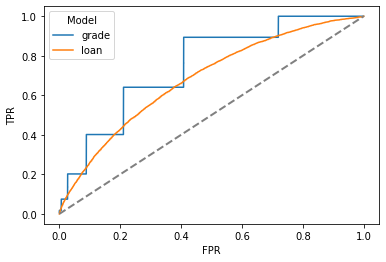

In [99]:
# draw ROC curve
#plot ROC curve for the alternative model, that uses only
glm_loan_roc = simple_roc(df.Default==1,df.phat3)
glm_simple_roc['Model'] = 'grade'
glm_loan_roc['Model'] = 'loan'

New_ROC=glm_simple_roc.append(glm_loan_roc)
plt.figure()
ax = sns.lineplot(data=New_ROC, x="FPR", y="TPR",hue='Model')
plt.plot([0, 1], [0, 1], color='grey', linestyle='dashed',linewidth=2)

By comparing the lift table and the ROC curve, we can see that the original grade model is better. The possible reason might because the loan amount is not significant,also when thinking about the intercept, setting all variables to its fixed level, intercept won't make sense to be a negative number. Especially, when you have no loan amount, default rate would be NA

iii) Create the squared of the interest rate and add this variable to the last model. Is the coefficient on this variable significant? Please give an intuition for what the coefficients on both int_rate and its squared value imply for the relationship between defaults and the interest rate.

In [110]:
# fit gression uses loan_amnt, annual_inc,term, int_rate
df['int_rate_sqr']=df['int_rate']**2
y,X4 = dmatrices('Default ~ loan_amnt + annual_inc + term + int_rate + int_rate_sqr',df,return_type = 'dataframe')
logit_model4 = sm.GLM(y,X4,family=sm.families.Binomial()).fit()
logit_model4.summary() #regression output

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                Default   No. Observations:                39412
Model:                            GLM   Df Residuals:                    39406
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15196.
Date:                Fri, 16 Apr 2021   Deviance:                       30393.
Time:                        01:18:02   Pearson chi2:                 4.55e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -4.0353      0.167    -24.201      0.000      -4.362      -3.709
term[T. 60 months]     0.4680      0.035     13.190      0.000       0.398       0.538
loan_amnt           1.934e-06   2.31e-06      0.838      0.402   -2.59e-06    6.46e-06
annual_inc         -5.982e-06   4.64e-07    -12.905      0.000   -6.89e-06   -5.07e-06
int_rate              25.5300      2.458     10.385      0.000      20.712      30.348
int_rate_sqr         -44.9436      8.985     -5.002      0.000     -62.554     -27.333
======================================================================================
"""

The sqaured of interest rate variable is significant by the p-value in the output of regression. The riskier borrower would be assigned a higher interest rate and it